# Modelagem - Projeto Heart Disease
Neste notebook vamos treinar e avaliar modelos de Machine Learning para prever a presença de doença cardíaca. 
Partiremos do dataset já tratado na EDA (`heart_clean.csv`).

## Modelos que Iremos Testar

Iremos avaliar múltiplos modelos de classificação no nosso dataset, tanto **com** quanto **sem padronização** das features usando `StandardScaler`.  
As principais métricas de avaliação serão: **Acurácia**, **Relatório de Classificação** e **Matriz de Confusão**.

### 1️⃣ Logistic Regression
- **Tipo**: Classificador supervisionado linear
- **Características**:
  - Modela a probabilidade de cada classe usando a função logística
  - Adequado para problemas lineares e multiclasse
- **Pontos fortes**:
  - Simples, rápido, interpretável
- **Limitações**:
  - Pode ter desempenho ruim em problemas não lineares

### 2️⃣ Decision Tree Classifier
- **Tipo**: Classificador supervisionado baseado em árvore de decisão
- **Características**:
  - Divide os dados em nós internos baseados em condições nas features
  - Folhas representam a classe final
- **Pontos fortes**:
  - Fácil de interpretar e visualizar
  - Captura relações não lineares
- **Limitações**:
  - Árvores profundas podem overfitar
  - Sensível a pequenas variações nos dados

### 3️⃣ Random Forest Classifier
- **Tipo**: Ensemble de árvores de decisão
- **Características**:
  - Constrói múltiplas árvores de decisão e combina suas previsões
  - Reduz overfitting em comparação com uma única árvore
- **Pontos fortes**:
  - Maior robustez e acurácia que uma árvore única
  - Captura relações complexas
- **Limitações**:
  - Mais lento para treinar e prever
  - Menos interpretável que uma árvore simples

### 4️⃣ AdaBoost Classifier
- **Tipo**: Ensemble baseado em boosting
- **Características**:
  - Combina múltiplos classificadores fracos sequencialmente
  - Cada novo modelo corrige os erros do anterior
- **Pontos fortes**:
  - Geralmente melhora a performance de modelos simples
  - Reduz bias do modelo base
- **Limitações**:
  - Sensível a outliers
  - Pode overfitar se `n_estimators` for muito alto

### 5️⃣ K-Nearest Neighbors (KNN)
- **Tipo**: Classificador baseado em instâncias
- **Características**:
  - Classifica uma amostra com base nas classes dos vizinhos mais próximos
  - Não faz suposições sobre a distribuição dos dados
- **Pontos fortes**:
  - Simples e intuitivo
  - Funciona bem para problemas com fronteiras complexas
- **Limitações**:
  - Lento para grandes conjuntos de dados
  - Sensível à escala das features (necessita padronização)


In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Carregar dataset tratado
Usaremos o `heart_clean.csv`, gerado na etapa de EDA.

In [63]:
df = pd.read_csv("/Users/laisbertoni/Documents/data-analysis-projects/data-analysis-projects/projeto-03-heart-disease/data/processed/heart_clean.csv")
df

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_unknown
0,52,125,212.0,168.0,1.0,0,False,True,True,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,True
1,53,140,203.0,155.0,3.1,0,False,True,True,False,False,False,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,True
2,70,145,174.0,125.0,2.6,0,False,True,True,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False,False,True
3,61,148,203.0,161.0,0.0,0,False,True,True,False,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,True
4,62,138,294.0,106.0,1.9,0,True,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,120,211.0,115.0,1.5,1,True,False,False,False,True,False,True,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False
298,44,108,141.0,175.0,0.6,1,True,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True,False
299,52,128,255.0,161.0,0.0,0,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,True
300,59,160,273.0,125.0,0.0,0,False,True,False,False,False,True,True,False,True,False,False,True,False,False,False,True,True,False,False,False,False,False,True,False


## Separação de treino e teste
Dividiremos o dataset em 80% treino e 20% teste, garantindo reprodutibilidade (`random_state=42`).


In [64]:
X = df.drop("target", axis= 1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)

## Treinamento e Avaliação dos Modelos

- Iremos separar o treinamento em **dois blocos**:
  1. **Sem padronização**: treino direto com os dados originais.
  2. **Com padronização**: uso do `StandardScaler` para padronizar as features numéricas.

- Criaremos **duas funções** para treinar os modelos e gerar um relatório de desempenho:
  - Uma função para treinamento **sem `StandardScaler`**.
  - Outra função para treinamento **com `StandardScaler`**.

- **Métricas principais a serem avaliadas**:
  - **Acurácia** (`accuracy`)
  - **Relatório de Classificação** (`classification_report`)
  - **Matriz de Confusão** (`confusion_matrix`)

**Obs:** Os modelos que não são baseados em árvores de decisão tem mais beneficio ao aplicar a padronização com o StandardScaler

In [ ]:
# Função sem a padronização
def ml_relatorio(mod, X_train, y_train, X_test, y_test, opt = 2):

    if opt == 0:
        model = mod(max_iter = 2000)
    elif opt == 1:
        model = mod(n_estimators = 1000)
    elif opt == 2:
        model = mod()

    # Treinamento
    model.fit(X_train, y_train)

    # Predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    train_report = classification_report(y_train, y_pred_train)
    test_report = classification_report(y_test, y_pred_test)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred_test)

    print(f"Acurácia Treino: {train_score * 100:.2f}%")
    print(f"Acurácia Teste: {test_score * 100:.2f}%")

    print("--- CLASSIFICATION REPORT ---")
    print(f"Treino: {train_report}")
    print(f"Teste: {test_report}")

    print("--- CONFUSION MATRIX ---")
# Heatmap de treino
    plt.figure(figsize=(6,4))
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.show()

    # Heatmap de teste
    plt.figure(figsize=(6,4))
    sns.heatmap(test_cm, annot=True, cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.show()
    

    return train_score, test_score

In [103]:
# Função com a padronização
def ml_relatorio_scaler(mod, X_train, y_train, X_test, y_test, opt = 2):

    
    scaler = StandardScaler()
    cols_scaler = [c for c in df.columns if df[c].nunique() > 5]
    X_train[cols_scaler] = scaler.fit_transform(X_train[cols_scaler])
    X_test[cols_scaler] = scaler.fit_transform(X_test[cols_scaler])

    if opt == 0:
        model = mod(max_iter = 2000)
    elif opt == 1:
        model = mod(n_estimators = 1000)
    elif opt == 2:
        model = mod()

    # Treinamento
    model.fit(X_train, y_train)

    # Predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    train_report = classification_report(y_train, y_pred_train)
    test_report = classification_report(y_test, y_pred_test)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred_test)

    print(f"Acurácia Treino: {train_score * 100:.2f}%")
    print(f"Acurácia Teste: {test_score * 100:.2f}%")

    print("--- CLASSIFICATION REPORT ---")
    print(f"Treino: {train_report}")
    print(f"Teste: {test_report}")

    print("--- CONFUSION MATRIX ---")
# Heatmap de treino
    plt.figure(figsize=(6,4))
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.show()

    # Heatmap de teste
    plt.figure(figsize=(6,4))
    sns.heatmap(test_cm, annot=True, cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.show()

    return train_score, test_score

Acurácia Treino: 89.63%
Acurácia Teste: 83.61%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.92      0.85      0.88       110
           1       0.88      0.94      0.91       131

    accuracy                           0.90       241
   macro avg       0.90      0.89      0.89       241
weighted avg       0.90      0.90      0.90       241

Teste:               precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

--- CONFUSION MATRIX ---


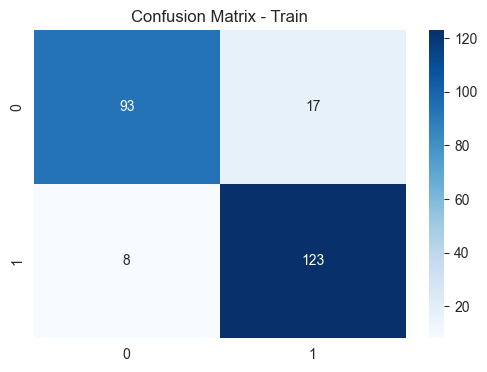

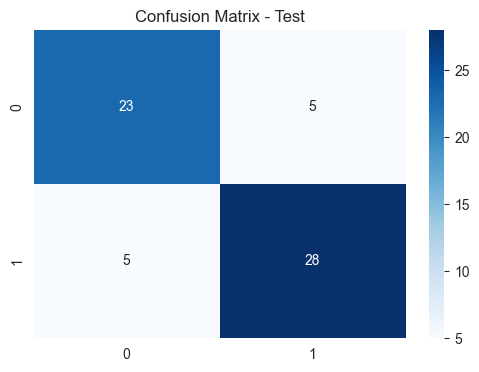

In [83]:
log_train, log_test = ml_relatorio(LogisticRegression, X_train, y_train, X_test, y_test, opt = 0)

Acurácia Treino: 100.00%
Acurácia Teste: 63.93%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       131

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Teste:               precision    recall  f1-score   support

           0       0.60      0.64      0.62        28
           1       0.68      0.64      0.66        33

    accuracy                           0.64        61
   macro avg       0.64      0.64      0.64        61
weighted avg       0.64      0.64      0.64        61

--- CONFUSION MATRIX ---


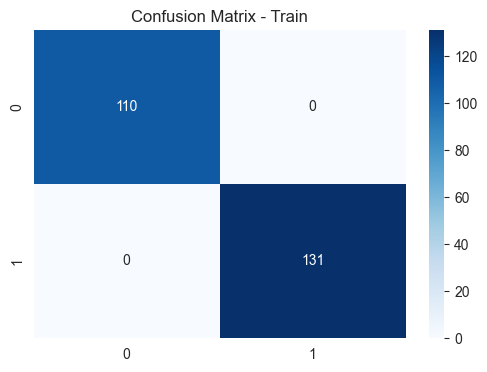

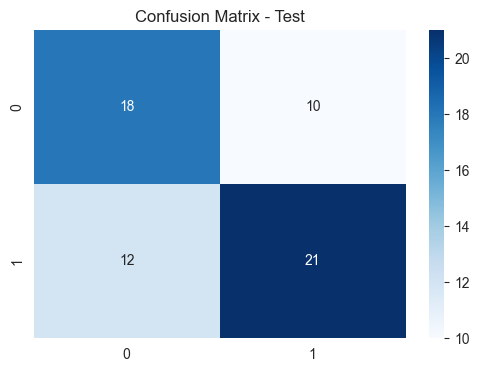

In [86]:
tree_train, tree_test = ml_relatorio(DecisionTreeClassifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 91.70%
Acurácia Teste: 78.69%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.92      0.90      0.91       110
           1       0.92      0.93      0.92       131

    accuracy                           0.92       241
   macro avg       0.92      0.92      0.92       241
weighted avg       0.92      0.92      0.92       241

Teste:               precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.83      0.76      0.79        33

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61

--- CONFUSION MATRIX ---


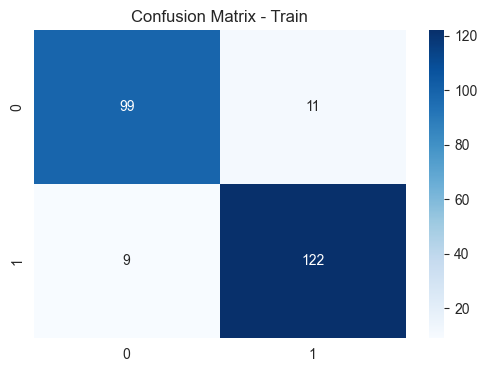

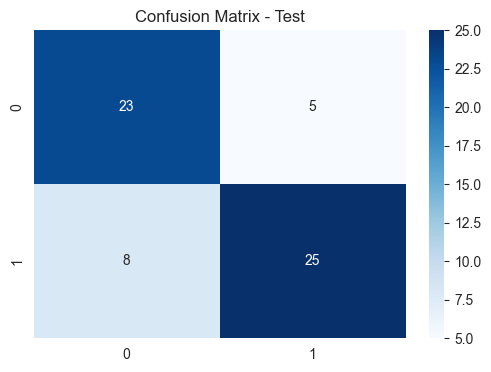

In [87]:
ada_train, ada_test = ml_relatorio(AdaBoostClassifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 78.42%
Acurácia Teste: 60.66%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.79      0.72      0.75       110
           1       0.78      0.84      0.81       131

    accuracy                           0.78       241
   macro avg       0.79      0.78      0.78       241
weighted avg       0.78      0.78      0.78       241

Teste:               precision    recall  f1-score   support

           0       0.58      0.54      0.56        28
           1       0.63      0.67      0.65        33

    accuracy                           0.61        61
   macro avg       0.60      0.60      0.60        61
weighted avg       0.60      0.61      0.61        61

--- CONFUSION MATRIX ---


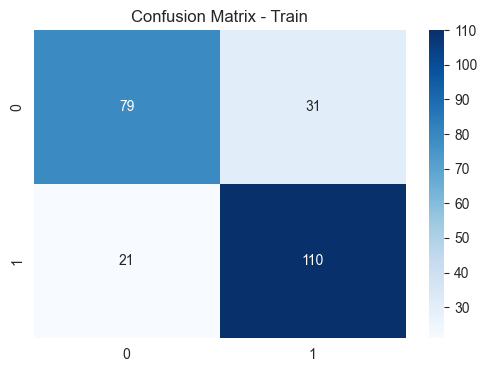

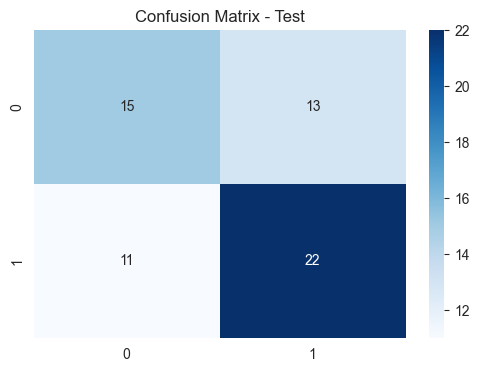

In [88]:
kn_train, kn_test = ml_relatorio(KNeighborsClassifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 88.38%
Acurácia Teste: 81.97%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.92      0.82      0.87       110
           1       0.86      0.94      0.90       131

    accuracy                           0.88       241
   macro avg       0.89      0.88      0.88       241
weighted avg       0.89      0.88      0.88       241

Teste:               precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.82      0.85      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

--- CONFUSION MATRIX ---


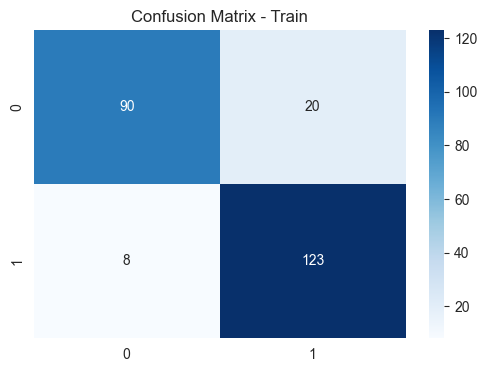

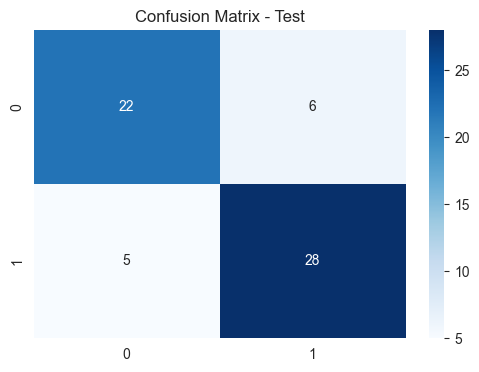

In [107]:
log_train_scaler, log_test_scaler = ml_relatorio_scaler(LogisticRegression, X_train, y_train, X_test, y_test, opt = 0)

Acurácia Treino: 100.00%
Acurácia Teste: 72.13%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       131

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Teste:               precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.74      0.76      0.75        33

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61

--- CONFUSION MATRIX ---


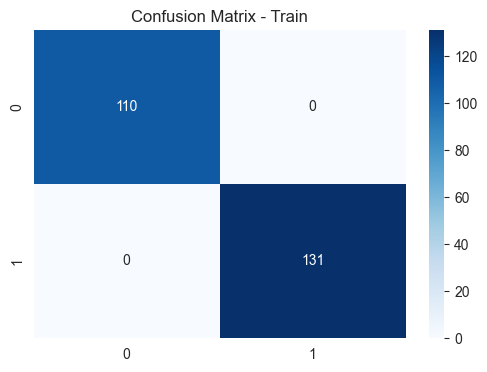

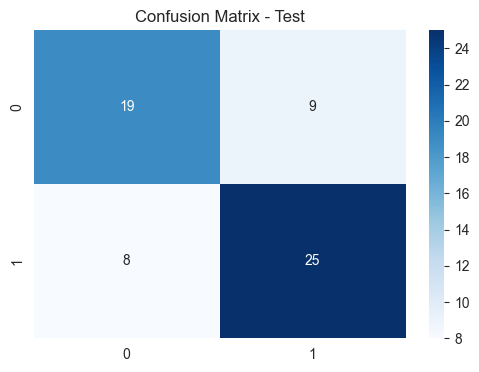

In [106]:
tree_train_scaler, tree_test_scaler = ml_relatorio_scaler(DecisionTreeClassifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 91.70%
Acurácia Teste: 83.61%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.92      0.90      0.91       110
           1       0.92      0.93      0.92       131

    accuracy                           0.92       241
   macro avg       0.92      0.92      0.92       241
weighted avg       0.92      0.92      0.92       241

Teste:               precision    recall  f1-score   support

           0       0.80      0.86      0.83        28
           1       0.87      0.82      0.84        33

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

--- CONFUSION MATRIX ---


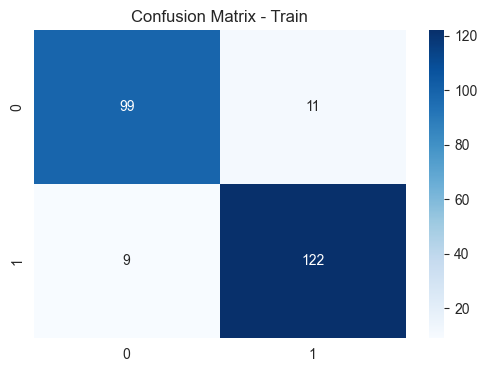

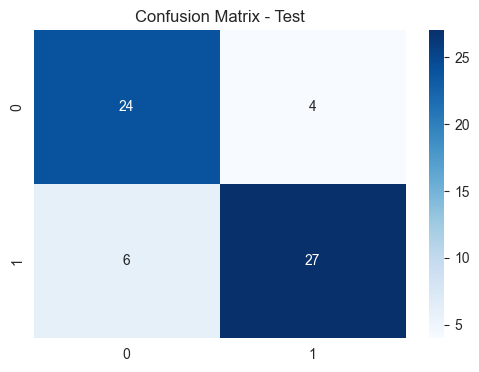

In [108]:
ada_train_scaler, ada_test_scaler = ml_relatorio_scaler(AdaBoostClassifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 88.38%
Acurácia Teste: 85.25%
--- CLASSIFICATION REPORT ---
Treino:               precision    recall  f1-score   support

           0       0.90      0.84      0.87       110
           1       0.87      0.92      0.90       131

    accuracy                           0.88       241
   macro avg       0.89      0.88      0.88       241
weighted avg       0.88      0.88      0.88       241

Teste:               precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.88      0.85      0.86        33

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

--- CONFUSION MATRIX ---


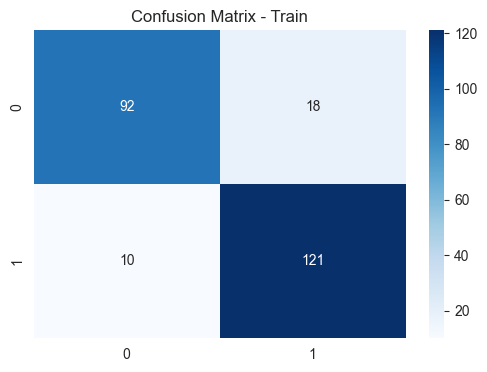

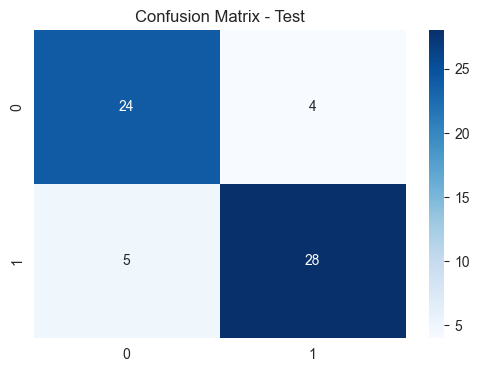

In [109]:
kn_train_scaler, kn_test_scaler = ml_relatorio_scaler(KNeighborsClassifier, X_train, y_train, X_test, y_test)